In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mnist import MNIST
import random

In [2]:
def count_numspercent(num, arr):
    print(np.count_nonzero(arr == num)/len(arr))
    
def printShape(name, arr):
    print("{0} shape:".format(name) + str(arr.shape))

In [3]:
mndata = MNIST("dat")
train = np.array(mndata.load_training()).T
test = np.array(mndata.load_testing()).T

# testLabels = test[:, 1]

# for i in range(10):
#    count_numspercent(i, testLabels)
    
# print(type(test[0]))

In [4]:
    def smd(z):
        """sigmoid function"""
        return 1 / (1 + np.exp(-z))
    
    def difsmd(z):
        return smd(z) * (1 - smd(z))
    
    def oneHot(y):
        arr = np.zeros(10)
        arr[y] = 1
        return np.array([arr]).T
    
    def reLU(z):
        return np.maximum(0, z)
    
    def difReLU(z):
        if isinstance(z, np.ndarray):
            z = np.array([i > 0 for i in z])
            return z
        
        return z > 0
    
    def softMax(z, z_arr):
        sum_exp_arr = sum(np.exp(z_arr))
        
        if isinstance(z, np.ndarray):
            arr = np.array([np.exp(i)/sum_exp_arr for i in z])
            return arr
        
        return np.exp(z)/sum(np.exp(z_arr))
    
    

In [5]:
class NeuralNetwork(object):
    def __init__(self, sizes):
        """
        constructor for a neural network.
        from https://github.com/mnielsen/neural-networks-and-deep-learning/
             blob/master/src/network.py
        """
        self.nLayers = len(sizes)
        self.sizes = sizes
        
        # array of bias vectors, list with `nLayers` amount of vecs
        # containing `size` elements
        
        self.biases = [np.random.randn(nextSize, 1) \
                       for nextSize in sizes[1:]]
        
        # array of weight matrices, if the previous layer is 
        # sized a, and next layer b, the weight matrix would
        # be sized (b * a) to accomodate transformation
        # (b * 1) = (b * a) . (a * 1)
        
        self.weights = [np.random.randn(nextSize, prevSize) \
                        for prevSize, nextSize in zip(sizes[:-1], sizes[1:])]
        
        self.prev_nab_W = [np.zeros(w.shape) for w in self.weights]
        self.prev_nab_B = [np.zeros(b.shape) for b in self.biases]
    
    def stochasticGradDesc(self, trainDat, nEpoch, sSSize, rate, testDat = None):
        
        print(f"starting SGD with batch size {sSSize}, learning rate {rate}")
        print(f"up to {nEpoch} epochs")
        
        if testDat is not None: 
            nTest = len(testDat)
            percent_list = []
        
        nTrain = len(trainDat)
        
        for i in range(nEpoch):
            random.shuffle(trainDat)
            
            subSets = [train[k : k + sSSize] for k in range(0, nTrain, sSSize)]
            
            for subSet in subSets:
                self.updSubSet(subSet, rate)
                
            if testDat is not None:
                percent = self.evaluate(testDat)/nTest
                print("Epoch {0} accuracy: {1:.1%} = 100 * {2}/{3}.".format( \
                    i, percent, self.evaluate(testDat), nTest))
                percent_list.append(percent)
            
            else:
                print("Epoch {0} complete".format(i))
                
        plt.plot(np.arange(nEpoch), percent_list, "k--")
        print("end.")
        plt.show()
        
    def feedFwd(self, arr):
        """
        forward feeding
        """
        arr = np.array([arr]).T
        # printShape("input_arr", arr)
        
        # i = 0 
        
        for b, w in zip(self.biases, self.weights):
            z = w @ arr + b
            # printShape("weight {0}".format(i), w)
            arr = smd(z)
            # printShape("output_arr {0}".format(i), arr)
            # i += 1
            
        # print(arr)
        # print("end")
        
        return arr

    def evaluate(self, testDat):
        results = [(np.argmax(self.feedFwd(x)), y) for (x, y) in testDat]
        # tuple (int, int)
        return sum(int(x == y) for x, y in results)
        
        
    def updSubSet(self, subSet, rate):
        
        # initialise weight gradients and bias gradients
        
        nabB = [np.zeros(b.shape) for b in self.biases]
        nabW = [np.zeros(w.shape) for w in self.weights]
        
        set_size = len(subSet)
        batch_rate = rate/set_size
        
        # update
        
        for x, y in subSet:
            delNabB, delNabW = self.propBwd(x, y)
            
            nabB = [nB + dnB for (nB, dnB) in zip(nabB, delNabB)]
            nabW = [nW + dnW for (nW, dnW) in zip(nabW, delNabW)]
            
            
        self.weights = [Wi - batch_rate * nabWi \
                        for Wi, nabWi in zip(self.weights, nabW)]
        
        self.biases = [Bi - batch_rate * nabBi \
                       for Bi, nabBi in zip(self.biases, nabB)]
        
    def difCost(self, outAct, y):
        return outAct - y # (10 * 1)
        
    def propBwd(self, x, y):
        """
        backwards propagation
        
        x - activation layer: ndarray, size m * 1
        y - output: int, could be converted to ndarray, size 10 * 1
            with oneHot(y).
            
        return:
        """
        
        # initialise weight gradients and bias gradients
        
        nabB = [np.zeros(b.shape) for b in self.biases]
        nabW = [np.zeros(w.shape) for w in self.weights]
        
        # forward propagation
        
        act = np.array([x]).T
        
        acts = [act]
        
        zVecs = []
        
        # feedFwd is not called to store the z and a values
        
        for b, w in zip(self.biases, self.weights):
            z = (w @ act) + b # (m * 1)
            act = smd(z)
            
            zVecs.append(z)
            acts.append(act)
            
            
        # bwd; output (acts[-1]) to first hidden (acts[-2])
        delta = self.difCost(acts[-1], oneHot(y))
        
        nabW[-1] = delta @ np.array(acts[-2]).T + (0.7 * self.prev_nab_W[-1])
        nabB[-1] = delta + (0.7 * self.prev_nab_B[-1]) # (out * 1)
        
        # for the rest of the network
        
        for l in range(2, self.nLayers):
            z = zVecs[-l]
            
            delta = (self.weights[-l + 1].T @ delta) * difsmd(z)
            
            nabW[-l] = delta @ acts[-l - 1].T + (0.7 * self.prev_nab_W[-l]) # (m * 1). (1 * m) = (m * m)
            nabB[-l] = delta + (0.7 * self.prev_nab_B[-l])  # m * 1
        
        self.prev_nab_W = nabW
        self.prev_nab_B = nabB
        
        return (nabB, nabW)

starting SGD with batch size 16, learning rate 0.0001
up to 12 epochs


<ipython-input-4-4716345d72a5>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch 0 accuracy: 11.7% = 100 * 1170/10000.
Epoch 1 accuracy: 13.3% = 100 * 1333/10000.
Epoch 2 accuracy: 14.8% = 100 * 1479/10000.
Epoch 3 accuracy: 17.2% = 100 * 1717/10000.
Epoch 4 accuracy: 17.9% = 100 * 1789/10000.
Epoch 5 accuracy: 18.2% = 100 * 1816/10000.
Epoch 6 accuracy: 18.3% = 100 * 1831/10000.
Epoch 7 accuracy: 16.3% = 100 * 1630/10000.
Epoch 8 accuracy: 15.6% = 100 * 1563/10000.
Epoch 9 accuracy: 16.0% = 100 * 1596/10000.
Epoch 10 accuracy: 16.0% = 100 * 1603/10000.
Epoch 11 accuracy: 15.7% = 100 * 1566/10000.
end.


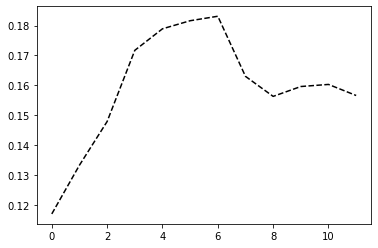

In [6]:
neuNet = NeuralNetwork([784, 16, 10])

neuNet.stochasticGradDesc(train, 12, 2**4, 1e-4, testDat = test)